# LSTM model
from https://github.com/Xinyi6/DP-LSTM-Differential-Privacy-inspired-LSTM-for-Stock-Prediction-Using-Financial-News and make some changes

### Where we can use big compute:
- Adding noises to data
- The computations of multi-sequence predictions
- The calculation of MSE

### Where we cannot use big compute:
- The training of LSTM


## COG Model

In [3]:
import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats

import matplotlib.pyplot as plt

stock = 'RIOT'
industry = 'cryptocurrency'

In [2]:
# read data
data = pd.read_csv('../../data/processed_data/data/processed_data_' + industry + '.csv')
data.head(5)

,window,NewsScore,StockPrice_IXIC,StockPrice_RIOT,StockPrice_MARA,StockPrice_BTC
0,"Row(start=datetime.datetime(2016, 3, 30, 20, 0...","[0.0421090909090909, 0.04210909090909092, 0.23...","[0.34565533783488345, 0.3492407538118469, 0.0,...","[0.0, 0.5000001528324282, 0.37179483652584994,...","[1.0, 0.5000003311370119, 0.44444481237445765,...","[0.0, 0.163067914819961, 0.16650270286716903, ..."
1,"Row(start=datetime.datetime(2016, 3, 31, 20, 0...","[0.2396555555555556, 0.2396555555555556, 0.381...","[0.10478549700277355, 0.9292240762279681, 0.92...","[0.0, 0.061224916784618985, 0.0612249167846189...","[1.0, 0.875000186264415, 0.8000002980230646, 0...","[0.0, 0.15948747901000218, 0.22089184168471604..."
2,"Row(start=datetime.datetime(2016, 4, 1, 20, 0)...","[0.3818, 0.3818, 0.6705, 0.6705, 0.0399, 0.039...","[0.9215968059407712, 0.9139695356535743, 0.906...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5434784974854...","[0.9142858602561642, 0.8285717205123283, 0.742...","[0.0, 0.3621434433251869, 0.4064723547395096, ..."
3,"Row(start=datetime.datetime(2016, 4, 2, 20, 0)...","[0.6705, 0.6705, 0.0399, 0.03990000000000001, ...","[0.6941069662074488, 0.6882657496584773, 0.682...","[0.0, 0.0, 0.0, 0.0, 0.5434784974854604, 0.847...","[0.7428575807684894, 0.6571434410246535, 0.571...","[0.28323415861740797, 0.23999136615828381, 0.3..."
4,"Row(start=datetime.datetime(2016, 4, 3, 20, 0)...","[0.0399, 0.03990000000000001, 0.34131, 0.34131...","[0.6812284384177699, 0.5112921773404069, 0.196...","[0.0, 0.0, 0.5434784974854604, 0.8478261658284...","[0.5714293012808177, 0.8571431004269392, 0.0, ...","[0.3034893475072235, 0.3267958145490044, 0.258..."


In [28]:
data.iloc[-2:]

,window,NewsScore,StockPrice_IXIC,StockPrice_COG,StockPrice_DVN,StockPrice_HFC
1831,"Row(start=datetime.datetime(2021, 4, 4, 20, 0)...","[0.0, 0.0, 0.5825199999999999, 0.6053, 0.99182...","[0.0, 0.24937955433519907, 0.19548878797479494...","[1.0, 0.8511621511328755, 0.9395344298362343, ...","[1.0, 0.4476737545396579, 0.6220930941753764, ...","[1.0, 0.7259479466253834, 0.763848017136108, 0..."
1832,"Row(start=datetime.datetime(2021, 4, 5, 20, 0)...","[0.5825199999999999, 0.6053, 0.991828571428571...",NaN,NaN,NaN,NaN


In [33]:
data = data.iloc[:-1]
# ratio of train and test data 0.8:0.2
train_len = int(len(data)*0.8)
test_len = len(data) - train_len

### 2. Processing data

In [30]:
def str2num(row):
    l = row.split(',')
    result = []
    result.append(float(l[0][1:]))
    for n in l[1:-1]:
        result.append(float(n))
    result.append(float(l[-1][:-1]))
    return result

In [34]:
df_prices_train = list(data['StockPrice_' + stock.upper()][:train_len])
df_prices_test = list(data['StockPrice_' + stock.upper()][train_len:])
df_senti_train = list(data['NewsScore'][:train_len])
df_senti_test = list(data['NewsScore'][train_len:])


In [35]:
# prepare train and test data
def input_data(df_prices, df_senti):
    x = []
    y = []
    for i, row in enumerate(df_prices):
        if type(row) == float:
            print(row)
        prices = str2num(row)
        senti = str2num(df_senti[i])
        one_row = []
        for i, p in enumerate(prices[:-1]):
            one_row.append([p, senti[i]])
        x.append(one_row)
        y.append(prices[-1])
    x = np.array(x)
    y = np.array(y)
    return x, y

In [36]:
x_train, y_train = input_data(df_prices_train, df_senti_train)
x_test, y_test = input_data(df_prices_test, df_senti_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1465, 21, 2) (1465,) (367, 21, 2) (367,)


In [38]:
# model parameters setting
split = 0.85 # train_data percent
sequence_length=21;  # is the window length of a subset
normalise= True  # normalize 3 features
batch_size=64;
input_dim=2  # ['price','sentiment']
input_timesteps=21 # the window length of a training data set
neurons=10  # number of neurons in one LSTM layer
epochs=10
prediction_len=1  # predict one day's price
dense_output=1  # output size of the last dense layer
drop_out=0.1  # dropout rate

In [39]:
# Build LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
# Compile model
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)

Epoch 1/10
23/23 [==============================] - 6s 23ms/step - loss: 0.3068
Epoch 2/10
23/23 [==============================] - 0s 20ms/step - loss: 0.1442
Epoch 3/10
23/23 [==============================] - 0s 20ms/step - loss: 0.1330
Epoch 4/10
23/23 [==============================] - 0s 17ms/step - loss: 0.1265
Epoch 5/10
23/23 [==============================] - 0s 15ms/step - loss: 0.1082
Epoch 6/10
23/23 [==============================] - 0s 15ms/step - loss: 0.0942
Epoch 7/10
23/23 [==============================] - 0s 15ms/step - loss: 0.1004
Epoch 8/10
23/23 [==============================] - 0s 14ms/step - loss: 0.0913
Epoch 9/10
23/23 [==============================] - 0s 15ms/step - loss: 0.0877
Epoch 10/10
23/23 [==============================] - 0s 16ms/step - loss: 0.0871


In [40]:
#multi sequence predict
prediction_seqs = model.predict(x_test).reshape(-1,) # prediction data
# !! parallelizable !!

'''
for x in x_test:
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
'''

'\nfor x in x_test:\n      temp=model.predict(curr_frame[newaxis,:,:])[0]\n      predicted.append(temp)\n      curr_frame = curr_frame[1:]\n      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)\n    prediction_seqs.append(predicted)\n'

In [41]:
np.sqrt(mean_squared_error(prediction_seqs, y_test))

0.27055610739054037

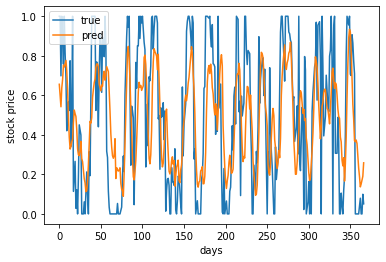

In [42]:
plt.plot(y_test, label = 'true')
plt.plot(prediction_seqs, label = 'pred')
plt.xlabel('days')
plt.ylabel('stock price')
plt.legend()

### De-normalized


In [45]:
ori_price = pd.read_csv('../../data/stock_price/data/' + industry +'/price_' + stock.upper() + '.csv')

In [44]:
ori_price.head(5)

,Date,Type,ticker,Price
0,2016-03-31,Open,COG,22.740000
1,2016-03-31,Closed,COG,22.709999
2,2016-04-01,Open,COG,22.260000
3,2016-04-01,Closed,COG,22.510000
4,2016-04-04,Open,COG,22.610001


In [46]:
def normalize(x):
    """
    Normalize the input to the range between 0 and 1
    """
    x = np.array(x)
    x_normalized = ((x - np.min(x)) / (np.max(x) - np.min(x))).tolist()
    return x_normalized
max_price = np.max(ori_price['Price'])
min_price = np.min(ori_price['Price'])
def denorm(x):
    x = np.array(x)
    x_denorm = (x * (max_price - min_price) + min_price).tolist()
    return x_denorm

In [48]:
print('Industry: ', industry, '; stock: ', stock.upper())
print('The max price is {0}, the min price is {1}'.format(max_price, min_price))
print('The RMSE of predictions is', np.sqrt(mean_squared_error(denorm(prediction_seqs), denorm(y_test))))

The max price is 29.489999771118164, the min price is 13.09000015258789
The MSE of predictions is 4.437120092289666


In [ ]:
# de_normalized
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])  # record_max is the max difference among prices, and record_min is the minimum price
      m=m+1
print(de_predicted)

# np.save(../stockdata/result2/sp_5dim_n01_7030.npy',de_predicted)

In [ ]:
error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)